Which is better - `GridSearchCV` or `RandomizedSearchCV`?

Let us understand with the help of scenarios.

## Infinite budget

Suppose we have infinite computational budget. This is practically possible if the dataset set size is small, i.e., the number of observations and the number of predictors are small.

In case of infinite budget, we can evaluate the cross-validated model score on all potential values of hyperparameters. Thus, in this case `GridSearchCV` is the better choice, as it won't leave out any possibility.

## Finite budget

Generally, we always have a finite compuational budget, and can perform a certain maximum number of model evaluations. However, let's consider 2 cases:

### Large number of hyperparameters
If we have a large number of hyperparameters, say $H$ and want to compute the cross validation score for at least 2 distinct values for each hyperparameter, then the number of models to be fit with `GridSearchCV` will be $2^H$. In this case, we'll certainly need to use `RandomizedSearchCV` for a large $H$.

### Small number of hyperparameters
Let us consider the case when we have a small number of hyperparameters, say 2. In this case which one will be better - `GridSearchCV` or `RandomizedSearchCV`? Let us consider an example.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score

#Libraries for visualizing trees
from sklearn.tree import export_graphviz 
from six import StringIO
from IPython.display import Image  
import pydotplus
import time as time

In [2]:
#Using the same datasets as in linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [3]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

### Example
Suppose we wish to optimize 2 hyperparameters - `max_samples` and `max_depth` for a bagged trees model that predicts car price. We wish to consider `max_depth` $\in \{2, 4, 6\}$, and `max_samples` $\in [0.4, 1.0]$. Suppose we have a computational budget of testing 9 combinations of hyperparameter values.

Which approach will be better?

#### `GridSearchCV`
With `GridSearchCV`, let us consider `max_samples` $\in \{0.4, 0.7, 1.0\}$ as we have a budget of testing 9 combinations of hyperparameter values, and we are already considering `max_depth` $\in \{2, 4, 6\}$

In [103]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator__max_depth':[2, 4, 6],
          'max_samples': [0.4, 0.7, 1.0]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_grid = GridSearchCV(BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1), 
                                                       random_state=1, n_jobs=-1, n_estimators = 200,
                                                      bootstrap = False), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                     scoring='neg_root_mean_squared_error')
bagging_regressor_grid.fit(X, y)

print('Train R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(X, y))
print('Test R^2 Score : %.3f'%bagging_regressor_grid.best_estimator_.score(Xtest, ytest))
print('Best RMSE through Grid Search : %.3f'%-bagging_regressor_grid.best_score_)
print('Best Parameters : ',bagging_regressor_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Train R^2 Score : 0.886
Test R^2 Score : 0.839
Best RMSE through Grid Search : 6304.919
Best Parameters :  {'base_estimator__max_depth': 6, 'max_samples': 0.7}


We get a cross-validated RMSE of $6304.92 with `GridSearchCV`.

In [106]:
#GridSearchCV results
cv_results = pd.DataFrame(bagging_regressor_grid.cv_results_)

#### `RandomizedSearchCV`
With `RandomizedSearchCV`, we can consider as many distinct values of `max_samples` as we wish, where `max_samples` $\in [0.4, 1.0]$, since we control the number of combinations of hyperparameter values (`n_iter`) for which the cross validation score will be computed. Let us consider `max_samples` $\in [0.4 , 0.47, 0.54, 0.61, 0.68, 0.75, 0.82, 0.89, 0.96]$

In [109]:
n_samples = train.shape[0]
n_features = train.shape[1]

params = {'base_estimator__max_depth':[2, 4, 6],
          'max_samples': np.arange(0.4,1.01,0.07)}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_regressor_rgrid = RandomizedSearchCV(BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=1), 
                                                             random_state=1, n_jobs=-1, n_estimators = 200,
                                                             bootstrap = False), 
                                      param_distributions =params, cv=cv, n_jobs=-1, verbose=1, n_iter = 9,
                                           random_state=1, scoring='neg_root_mean_squared_error')
bagging_regressor_rgrid.fit(X, y)

print('Train R^2 Score : %.3f'%bagging_regressor_rgrid.best_estimator_.score(X, y))
print('Test R^2 Score : %.3f'%bagging_regressor_rgrid.best_estimator_.score(Xtest, ytest))
print('Best RMSE through random Search : %.3f'%-bagging_regressor_rgrid.best_score_)
print('Best Parameters : ',bagging_regressor_rgrid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Train R^2 Score : 0.885
Test R^2 Score : 0.840
Best RMSE through random Search : 6275.076
Best Parameters :  {'max_samples': 0.6100000000000001, 'base_estimator__max_depth': 6}


We get a cross-validated RMSE of $6275.08 with `RandomizedSearchCV`, which is better than what we got with `GridSearchCV`. Although not gauranteed, `RandomizedSearchCV` is likely to do better than `GridSearchCV` even for a few hyperparameter values.

Let us understand this by analyzing the cross validated results of both types of searches.

In [107]:
#RandomizedSearchCV results
cv_resultsr = pd.DataFrame(bagging_regressor_rgrid.cv_results_)

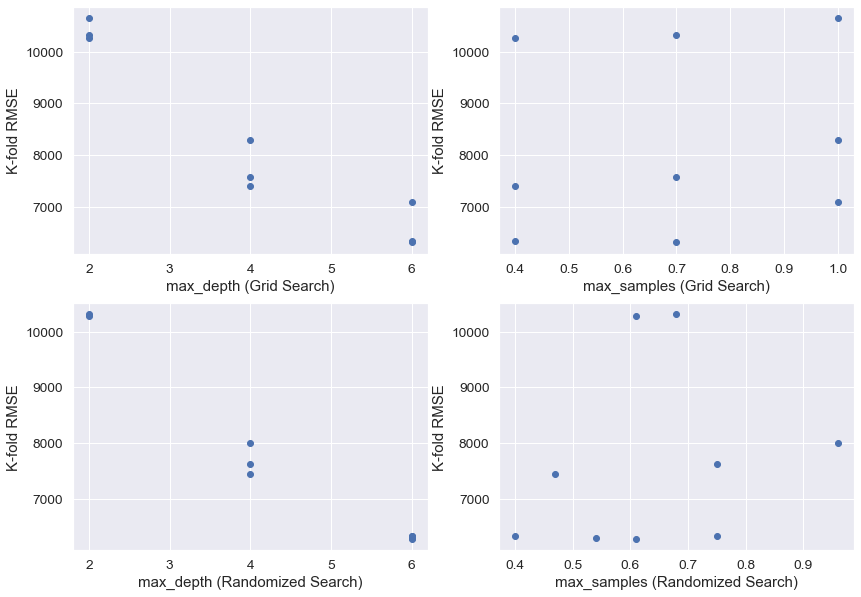

In [112]:
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)

#GridSearchCV
fig, axes = plt.subplots(2,2,figsize=(14,10))
plt.subplots_adjust(wspace=0.2)
axes[0, 0].plot(cv_results.param_base_estimator__max_depth, (-cv_results.mean_test_score), 'o')
axes[0, 0].set_xlabel('max_depth (Grid Search)')
axes[0, 0].set_ylabel('K-fold RMSE')
axes[0, 1].plot(cv_results.param_max_samples, (-cv_results.mean_test_score), 'o')
axes[0, 1].set_xlabel('max_samples (Grid Search)')
axes[0, 1].set_ylabel('K-fold RMSE')

#RandomizedSearchCV
axes[1, 0].plot(cv_resultsr.param_base_estimator__max_depth, (-cv_resultsr.mean_test_score), 'o')
axes[1, 0].set_xlabel('max_depth (Randomized Search)')
axes[1, 0].set_ylabel('K-fold RMSE')
axes[1, 1].plot(cv_resultsr.param_max_samples, (-cv_resultsr.mean_test_score), 'o')
axes[1, 1].set_xlabel('max_samples (Randomized Search)')
axes[1, 1].set_ylabel('K-fold RMSE');

Note that the trend for `max_depth` appears to be similar for both the searches regardless of the value of `max_samples`. However, with `RandomizedSearchCV`, we are able to compute the cross validation score for more distinct values of `max_samples`. We are obtaining low cross-validated RMSEs for `max_samples` values of 0.54, 0.61, and 0.75, which we miss out in `GridSearchCV`. 

`GridSearchCV`, only searches 3 different values of `max_samples` in 9 iterations. However, `RandomizedSearchCV` can search 9 different values for the 9 iterations. As a result, it is much easier for `RandomizedSearchCV` to search for the optimal hyperparameters, and is thus more likely to find more optimal hyperparameter values.

Let us compute the RMSE on test data for the optimal models obtained with both types of search.

In [101]:
#RMSE for the optimal hyperparameters based on GridSearchCV
np.sqrt(mean_squared_error(test.price, bagging_regressor_grid.predict(Xtest)))

6661.573791208074

In [102]:
#RMSE for the optimal hyperparameters based on RandomizedSearchCV
np.sqrt(mean_squared_error(test.price, bagging_regressor_rgrid.predict(Xtest)))

6640.462268475577

We oberve that `RandomizedSearchCV` seems to have found slightly better optimal hyperparameter values than `GridSearchCV` for the same number of model fits. Though likely, this is not gauranteed to happen.